In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd

[[-1.32308993]]
[[-1.32308993]] [473.750606]


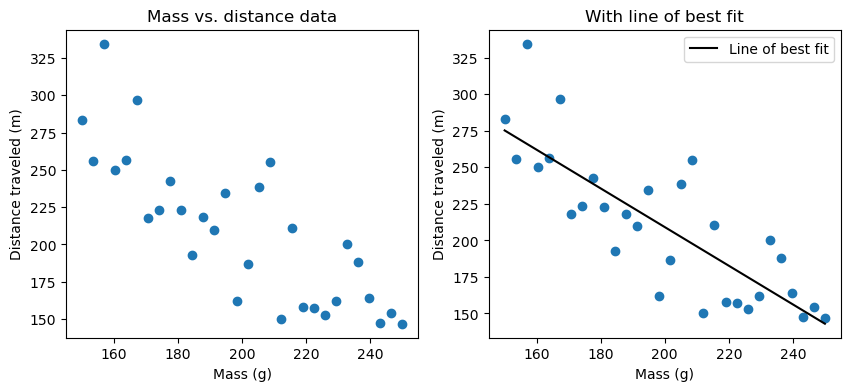

In [14]:
a_actual = -1.2
b_actual = 450
sigma = 30
npts = 30

np.random.seed(5)
rands = np.random.normal(loc=0.0, scale=sigma, size=(npts,))
inds = np.linspace(150, 250, npts, dtype=np.float64)
data = a_actual*inds + b_actual + rands
xhat = np.mean(inds)
yhat = np.mean(data)

model = LinearRegression().fit((inds-xhat)[:,None], (data-yhat)[:,None])
print(model.coef_)

plt.subplots(1, 2, figsize=(10,4))
# plt.subplot(122)
# plt.title('Mean-centered, fitting m only')
# plt.scatter(inds-xhat, data-yhat)
# plt.scatter([0],[0])
# plt.plot(inds-xhat, a_actual*inds + b_actual - yhat, 'r')
# plt.plot(inds-xhat, model.coef_[0,0]*(inds-xhat))

plt.subplot(121)
plt.scatter(inds, data)
plt.title('Mass vs. distance data')
plt.xlabel('Mass (g)')
plt.ylabel('Distance traveled (m)')

plt.subplot(122)
plt.title('With line of best fit')
plt.xlabel('Mass (g)')
plt.ylabel('Distance traveled (m)')
plt.scatter(inds, data)
# print(np.vstack([np.ones_like(inds), inds]).T)
model2 = LinearRegression(fit_intercept=True).fit(
    X=inds[:,None],
    y=data[:,None]
)
print(model2.coef_, model2.intercept_)
# plt.plot(inds, a_actual*inds + b_actual, 'r', label='Actual model')
plt.plot(inds, model2.coef_[0,0]*inds + model2.intercept_[0], 'k', label='Line of best fit')
# plt.scatter([xhat],[yhat])
plt.legend()


In [41]:
a_actual = 5
b_actual = 8
sigma = 30
npts = 40

np.random.seed(5)
rands = np.random.normal(loc=0.0, scale=sigma, size=(npts,))
inds = np.linspace(1, 50, npts, dtype=np.float64)
data = a_actual*inds + b_actual + rands
xhat = np.mean(inds)
yhat = np.mean(data)

model = LinearRegression().fit((inds-xhat)[:,None], (data-yhat)[:,None])
print(model.coef_)

m_slider = alt.binding_range(min=0, max=10, name="Slope (m): ")
m_var = alt.param(bind=m_slider, value=a_actual, name='m')
b_slider = alt.binding_range(min=-20, max=20, name="Intercept (b): ")
b_var = alt.param(bind=b_slider, value=b_actual, name='b')

line_df = pd.DataFrame({'x':inds,'y':data})

base = alt.Chart(line_df).mark_point().encode(
    x=alt.X('x:Q', title='Time', scale=alt.Scale(domain=[1, 50])),
    y=alt.Y('y:Q', title="Value", scale=alt.Scale(domain=[0, max(data)+10]))
)
lobf = alt.Chart().mark_rule().transform_calculate(
    y=f'{min(inds)}*m+b',
    y2=f'{max(inds)}*m+b'
).encode(
    x=alt.datum(min(inds)),
    x2=alt.datum(max(inds)),
    y=alt.Y('y:Q'),
    y2='y2:Q'
).add_params(
    m_var,
    b_var
)
lobf_ll = alt.Chart(line_df).transform_calculate(
    res='pow((datum.y - (datum.x*m+b)), 2)'
).transform_aggregate(
    s2='sum(res)',
    n='count()'
).transform_calculate(
    mse=alt.datum.s2/alt.datum.n,
    text=alt.Text('mse:Q', format='.3f')
).mark_text(fontSize=20).encode(
    y=alt.value(-25),
    text='text'
).add_params(
    m_var,
    b_var
)
chart = alt.layer(base, lobf, lobf_ll, padding={"left": 5, "top": 20, "right": 5, "bottom": 5})
# chart.save('lobf.vg.json')
chart

[[5.13766162]]


SchemaValidationError: '{'field': 'mse', 'format': '.3f', 'type': 'quantitative'}' is an invalid value for `calculate`. Valid values are of type 'string'.

(array([0.00215672, 0.00647015, 0.01380298, 0.03019403, 0.04831044,
        0.04831044, 0.03321343, 0.01941044, 0.01164627, 0.00215672]),
 array([151.12823836, 155.76491722, 160.40159609, 165.03827495,
        169.67495382, 174.31163268, 178.94831154, 183.58499041,
        188.22166927, 192.85834814, 197.495027  ]),
 <BarContainer object of 10 artists>)

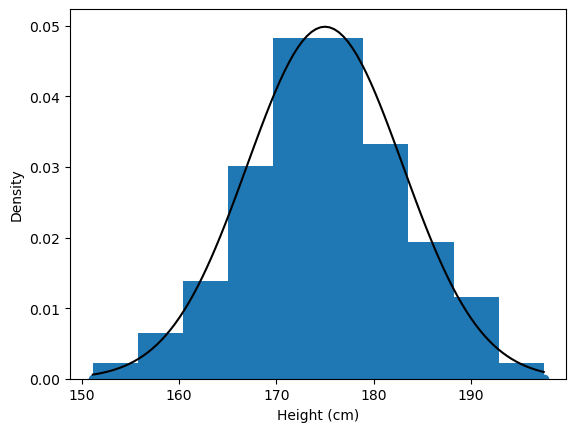

In [4]:
height_u = 175
height_s = 8
nsamples = 500

np.random.seed(3)
heights = np.random.normal(loc=height_u, scale=height_s, size=(nsamples,))
plt.scatter(heights, np.zeros_like(heights))
xs = np.linspace(np.min(heights), np.max(heights), 100)
plt.xlabel('Height (cm)')
plt.ylabel('Density')
plt.plot(xs, stats.norm.pdf(xs, loc=height_u, scale=height_s), 'k')
plt.hist(heights, density=True, bins=10)

In [5]:
u_slider = alt.binding_range(min=150, max=200, name="Mean (𝜇): ")
u_var = alt.param(bind=u_slider, value=165, name='u')
s_slider = alt.binding_range(min=1, max=30, name='Standard deviation (𝜎): ')
s_var = alt.param(bind=s_slider, value=3, name='s')

x_pts = np.linspace(min(heights), max(heights), 300)
height_df = pd.DataFrame({'h':heights})
norm_df = pd.DataFrame({'x':x_pts})

hist = alt.Chart(height_df).mark_bar().encode(
    alt.X('h:Q', title="Height (cm)").bin(step=1),
    y=alt.Y('sum(pct):Q', title="Density")
).transform_joinaggregate(
    total='count(*)'
).transform_calculate(
    pct='1 / datum.total'
)
gaussian = alt.Chart(norm_df).mark_line().transform_calculate(
    eps='exp(-pow((datum.x - u)/s,2)*0.5) * 1/(sqrt(2*PI)*s)',
).encode(
    x=alt.X('x:Q'),
    y=alt.Y('eps:Q'),
    color=alt.value('red')
).add_params(
    u_var,
    s_var
)
log_likelihood = alt.Chart(height_df).transform_calculate(
    ll='-pow((datum.h - u)/s,2)*0.5 - 0.5*log(2*PI) - log(s)'
).transform_aggregate(
    tll='sum(ll)'
).transform_calculate(
    lk=alt.datum.tll/alt.expr.log(10),
    lk_base=alt.expr.ceil(alt.datum.lk),
    lk_exp=alt.expr.pow(10,-(alt.datum.lk-alt.datum.lk_base)),
    lk_exp_rounded=alt.expr.round(alt.datum.lk_exp*100)/100,
    text="Data likelihood: " + alt.datum.lk_exp_rounded + "E" + alt.datum.lk_base
).mark_text().encode(
    y=alt.value(0),
    text='text:N'
).add_params(
    u_var,
    s_var
)

chart = hist + gaussian + log_likelihood
chart.save('gaussian-heights.vg.json')

In [6]:
print(heights.mean(), heights.std())

175.04834561727284 8.182457113626837
